In [20]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

import seaborn as sns
from matplotlib import pyplot as plt

from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve


The dataset - https://www.kaggle.com/competitions/playground-series-s4e1

task - binary classification predict chance of customer leaving (churn)

synthetically generated

In [2]:
subsample = pd.read_csv(r"C:\Users\flavi\Desktop\Py files\datasets\playground-series-s4e1\sample_submission.csv")
train = pd.read_csv(r"C:\Users\flavi\Desktop\Py files\datasets\playground-series-s4e1\train.csv")
test = pd.read_csv(r"C:\Users\flavi\Desktop\Py files\datasets\playground-series-s4e1\test.csv")

In [22]:
subsample

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5
...,...,...
110018,275052,0.5
110019,275053,0.5
110020,275054,0.5
110021,275055,0.5


In [23]:
def submission_csv(trained_model, test_data, indexes, filename):
    preds = trained_model.predict_proba(test_data)[:, 1]
    df_ = pd.DataFrame(zip(indexes, preds), columns= ["id", "Exited"])
    df_.to_csv(f"{filename}.csv", index=False)
    

In [3]:
train.shape, test.shape

((165034, 14), (110023, 13))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [5]:
train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [6]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


First observations
- no missing data
- target is exited
- some irrelevant columns: id, customerid, surname

In [7]:
train = train.drop(["CustomerId", "id", "Surname", "Gender"], axis=1)
test = test.drop(["CustomerId", "id", "Surname", "Gender"], axis=1)

In [8]:
train.columns = [c.lower() for c in train.columns]
test.columns = [c.lower() for c in test.columns]

Checking classs balance

In [9]:
train.exited.value_counts()

exited
0    130113
1     34921
Name: count, dtype: int64

Baseline model

In [10]:
X  = train.drop("exited", axis=1)
X = pd.get_dummies(X)
y = train.exited
X.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,geography_Spain
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,True,False,False
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,True,False,False
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,True,False,False
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,True,False,False
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,False,False,True


In [11]:
test = pd.get_dummies(test)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, stratify=y)
base_model = RandomForestClassifier(n_estimators=150)
base_model.fit(x_train, y_train)
base_preds = base_model.predict(x_test)
print(classification_report(y_test, base_preds))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     26023
           1       0.72      0.52      0.61      6984

    accuracy                           0.86     33007
   macro avg       0.80      0.73      0.76     33007
weighted avg       0.85      0.86      0.85     33007



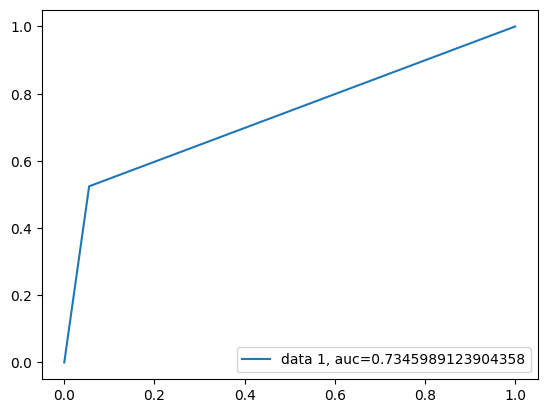

In [13]:
fpr, tpr, _ = roc_curve(y_test,  base_preds)
auc = roc_auc_score(y_test, base_preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

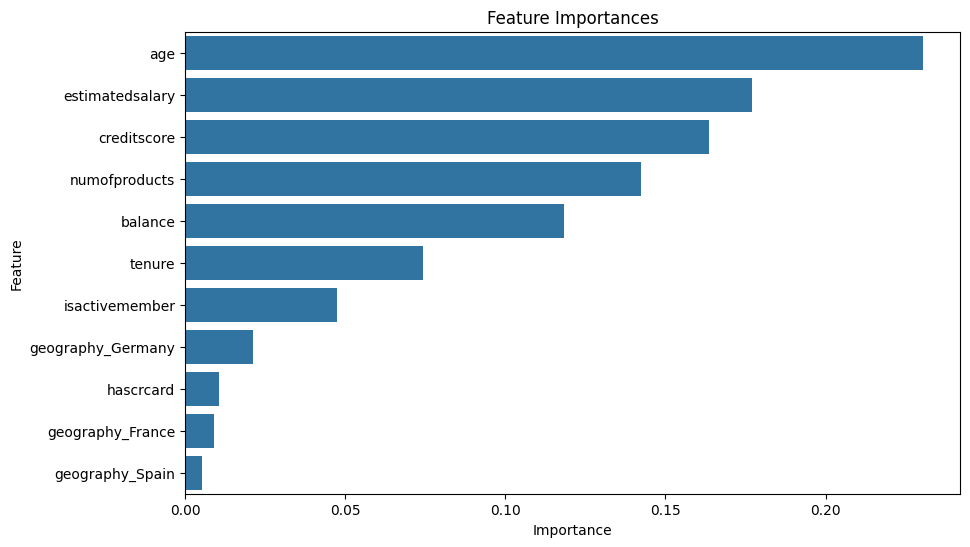

In [14]:
importances = base_model.feature_importances_

# Get feature names
feature_names = x_train.columns

# Sort feature importances in descending order
indices = importances.argsort()[::-1]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

the base model already has a fairly ok performance. Now let's maybe do some feature engineering and balance the classes 

In [15]:
oversampler = SMOTE(random_state= 0)
x , y = oversampler.fit_resample(X, y)

x_train_res, x_test_res, y_train_res, y_test_res =  train_test_split(x, y, test_size=0.25)   

In [16]:
x_train_res

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,geography_Spain
2323,619,31.000000,2,0.000000,2,0.000000,0.0,177522.010000,True,False,False
57958,662,71.000000,1,0.000000,1,1.000000,0.0,173844.890000,True,False,False
45630,683,30.000000,7,110829.520000,2,0.000000,0.0,24938.840000,True,False,False
164063,565,36.000000,8,130931.830000,1,1.000000,0.0,105642.430000,False,True,False
148001,569,39.000000,6,0.000000,2,1.000000,0.0,126792.860000,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
96301,638,51.000000,8,68375.270000,1,1.000000,0.0,198810.650000,False,False,True
10059,622,46.000000,9,0.000000,1,1.000000,1.0,131736.230000,True,False,False
141969,732,31.000000,4,0.000000,2,1.000000,1.0,103866.370000,True,False,False
166239,583,54.623344,5,104283.655578,1,0.053808,0.0,159639.344131,True,True,False


In [17]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0, n_jobs=-1) 
xgb.fit(x_train_res, y_train_res)
xgb_pred = xgb.predict(x_test_res)
print(classification_report(xgb_pred, y_test_res))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91     34347
           1       0.88      0.93      0.90     30710

    accuracy                           0.90     65057
   macro avg       0.90      0.90      0.90     65057
weighted avg       0.90      0.90      0.90     65057



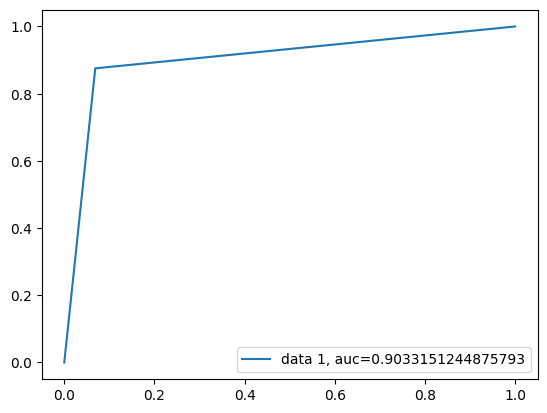

In [18]:
fpr, tpr, _ = roc_curve(y_test_res,  xgb_pred)
auc = roc_auc_score(y_test_res, xgb_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

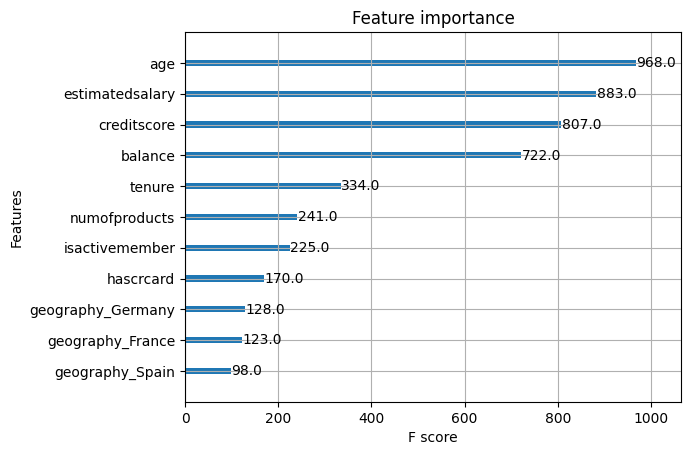

In [19]:
plot_importance(xgb)

just by oversampling and choosing a more robust ensemble, but sill baseline, we increase the f1 score. Lets save the output and perform gridsearch to see how much we can still improve

In [25]:
submission_csv(xgb,test, range(165034, 275057), "xgb not tuned")

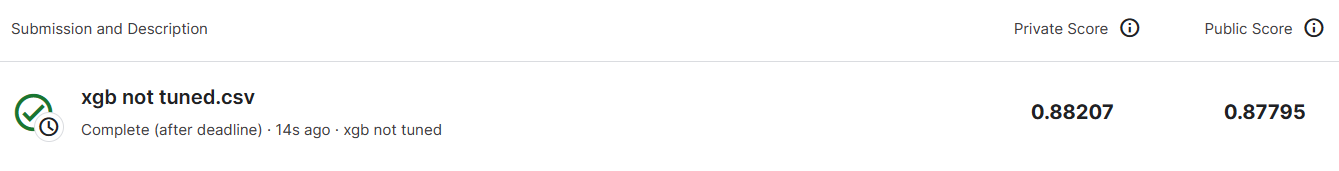

### Grid search hyperparameter tuning with cross validation

In [28]:
xgb2 = XGBClassifier(objective='binary:logistic', random_state=0) 

cv_params = {'max_depth': [4,5,6,7,8], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]
             }    

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb2, cv_params, scoring=scoring, cv=5, refit='f1')

In [29]:
%%time
xgb_cv.fit(x_train_res, y_train_res)

CPU times: total: 1h 22min 45s
Wall time: 14min 29s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [31]:
xgb_cv.best_params_

{'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 125}

In [33]:
new_preds = xgb_cv.best_estimator_.predict(x_test_res)
print(classification_report(y_test_res, new_preds))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     32529
           1       0.93      0.88      0.90     32528

    accuracy                           0.90     65057
   macro avg       0.90      0.90      0.90     65057
weighted avg       0.90      0.90      0.90     65057



since we actually did not improve the score using grid search, let's call it a day